## Create DF for Todays Games

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random
import shutil
import plotly
os.chdir('C:\\Users\\Travis\\OneDrive\\Data Science\\Personal_Projects\\Sports\\NBA_Prediction_V3_1')
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
import requests     
from scipy.stats import norm
import winsound
import warnings
warnings.filterwarnings('ignore')

In [2]:
today = datetime.date.today()
today = today.strftime('%Y-%m-%d')

In [3]:
today_df= pd.read_csv('data/team/aggregates/daily_updates/draftkings' + str(today) + '.csv')

# delete the O or U from the totals
today_df['TOTAL'] = today_df['TOTAL'].str.replace('O', '').str.strip()
today_df['TOTAL'] = today_df['TOTAL'].str.replace('U', '').str.strip()
today_df['TOTAL'] = today_df['TOTAL'].astype(float)

In [4]:
today_df

,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds
0,POR Trail Blazers,1.5,237.0,+105,−110,−110
1,IND Pacers,-1.5,237.0,−125,−110,−110
2,CHI Bulls,4.5,231.0,+155,−115,−110
3,PHI 76ers,-4.5,231.0,−180,−105,−110
4,BKN Nets,-4.0,231.0,−175,−115,−110
5,NO Pelicans,4.0,231.0,+150,−105,−110
6,NY Knicks,3.5,218.0,+140,−110,−110
7,TOR Raptors,-3.5,218.0,−165,−110,−110
8,CHA Hornets,9.5,232.0,+380,−110,−110
9,MIL Bucks,-9.5,232.0,−475,−110,−110


In [5]:
# convert names to nba-type names
# create a dictionary of names and their nba-type names
names_dict = {'ATL Hawks':'ATL',
                'BKN Nets':'BKN',
                'BOS Celtics':'BOS',
                'CHA Hornets':'CHA',
                'CHI Bulls':'CHI',
                'CLE Cavaliers':'CLE',
                'DAL Mavericks':'DAL',
                'DEN Nuggets':'DEN',
                'DET Pistons':'DET',
                'GS Warriors':'GSW',
                'HOU Rockets':'HOU',
                'IND Pacers':'IND',
                'LA Clippers':'LAC',
                'LA Lakers':'LAL',
                'MEM Grizzlies':'MEM',
                'MIA Heat':'MIA',
                'MIL Bucks':'MIL',
                'MIN Timberwolves':'MIN',
                'NO Pelicans':'NOP',
                'NY Knicks':'NYK',
                'OKC Thunder':'OKC',
                'ORL Magic':'ORL',
                'PHI 76ers':'PHI',
                'PHO Suns':'PHX',
                'POR Trail Blazers':'POR',
                'SAC Kings':'SAC',
                'SA Spurs':'SAS',
                'TOR Raptors':'TOR',
                'UTA Jazz':'UTA',
                'WAS Wizards':'WAS'}
                

In [6]:
today_df['trad_team'] = today_df['TODAY'].map(names_dict)
# reset index
today_df = today_df.reset_index(drop=False)

### Adding Features

We want to add everything after the in-game numbers, such as:

- General Game Info
- Running Averages 't1_running_trad_pts', 't1_running_trad_fgm', ...



#### Load Old_DF_Final (just like update_all_features)

In [7]:
old_df_final = pd.read_csv('data/team/All_Things_9.csv')

# sort by date
#old_df_final.trad_gamedate = pd.to_datetime(old_df_final.trad_gamedate)
old_df_final = old_df_final.sort_values(by=['trad_gamedate'], ascending=False)
old_df_final['trad_gamedate'] = pd.to_datetime(old_df_final['trad_gamedate'])
# drop unnamed columns
unnamed = [col for col in old_df_final.columns if 'Unnamed' in col]
old_df_final.drop(columns=unnamed, inplace=True)
print(old_df_final.shape)
old_df_final.head(1)

(22824, 834)


,trad_team,trad_matchup,trad_gamedate,trad_w/l,trad_min,trad_pts,trad_fgm,trad_fga,trad_fg%,trad_3pm,...,Opp_abbrev,Nba_com_team_Abbrev.1,Date_underscore,HomeTeam,AwayTeam,CREW CHIEF,REFEREE\n&\nUMPIRE,FULL GAME\nODDS URL,opponent,date_y
0,CHI,CHI @ NYK,2022-12-23,W,48.0,118.0,45.0,93.0,0.484,14.0,...,Nyk,NYK,12_23_2022,NYK,CHI,NaN,NaN,NaN,NYK,12_23_2022


In [8]:
# where index is even, matchup is next row. where index is odd, matchup is previous row
today_df['matchup'] = np.where(today_df.index % 2 == 0, today_df['trad_team'].shift(-1), today_df['trad_team'].shift(1))
today_df.head()

,index,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds,trad_team,matchup
0,0,POR Trail Blazers,1.5,237.0,+105,−110,−110,POR,IND
1,1,IND Pacers,-1.5,237.0,−125,−110,−110,IND,POR
2,2,CHI Bulls,4.5,231.0,+155,−115,−110,CHI,PHI
3,3,PHI 76ers,-4.5,231.0,−180,−105,−110,PHI,CHI
4,4,BKN Nets,-4.0,231.0,−175,−115,−110,BKN,NOP


In [9]:
today_df['AwayTeam'] = np.where(today_df.index % 2 == 0, today_df['trad_team'], today_df['matchup'].str[:3])
today_df['HomeTeam'] = np.where(today_df.index % 2 == 0, today_df['matchup'].str[:3], today_df['trad_team'])
today_df.head(3)

,index,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds,trad_team,matchup,AwayTeam,HomeTeam
0,0,POR Trail Blazers,1.5,237.0,+105,−110,−110,POR,IND,POR,IND
1,1,IND Pacers,-1.5,237.0,−125,−110,−110,IND,POR,POR,IND
2,2,CHI Bulls,4.5,231.0,+155,−115,−110,CHI,PHI,CHI,PHI


In [10]:
today_df['trad_matchup'] = today_df['AwayTeam'] + ' @ ' + today_df['HomeTeam']
today_df['trad_season'] = 2022
today_df['team_2'] = np.where(today_df.AwayTeam == today_df.trad_team, today_df.HomeTeam, today_df.AwayTeam)
today_df['trad_gamedate'] = today

today_df.head(2)

,index,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds,trad_team,matchup,AwayTeam,HomeTeam,trad_matchup,trad_season,team_2,trad_gamedate
0,0,POR Trail Blazers,1.5,237.0,+105,−110,−110,POR,IND,POR,IND,POR @ IND,2022,IND,2023-01-06
1,1,IND Pacers,-1.5,237.0,−125,−110,−110,IND,POR,POR,IND,POR @ IND,2022,POR,2023-01-06


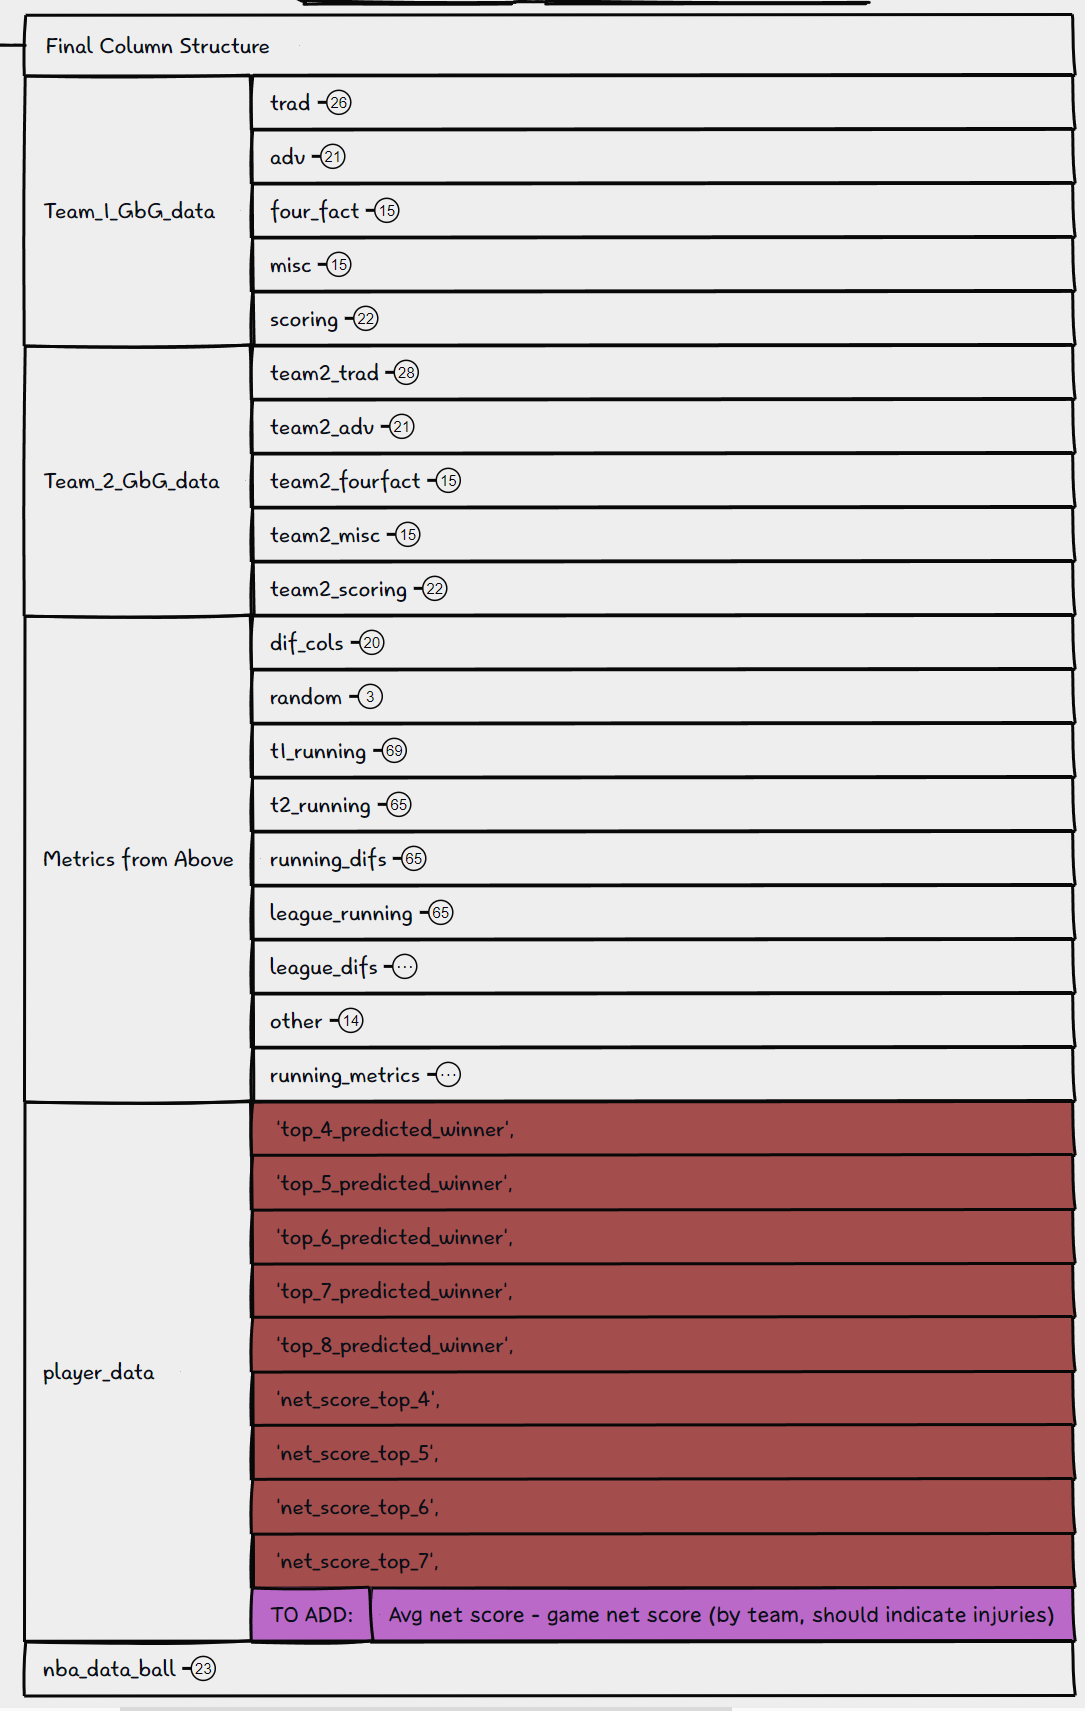

In [11]:
%matplotlib inline
from IPython.display import Image
Image('final_column_structure.png')

In [12]:
old_df_final.columns[3:100]

Index(['trad_w/l', 'trad_min', 'trad_pts', 'trad_fgm', 'trad_fga', 'trad_fg%',
       'trad_3pm', 'trad_3pa', 'trad_3p%', 'trad_ftm', 'trad_fta', 'trad_ft%',
       'trad_oreb', 'trad_dreb', 'trad_reb', 'trad_ast', 'trad_tov',
       'trad_stl', 'trad_blk', 'trad_pf', 'trad_+/-', 'trad_season',
       'trad_season_type', 'adv_team', 'adv_matchup', 'adv_gamedate',
       'adv_w/l', 'adv_min', 'adv_offrtg', 'adv_defrtg', 'adv_netrtg',
       'adv_ast%', 'adv_ast/to', 'adv_astratio', 'adv_oreb%', 'adv_dreb%',
       'adv_reb%', 'adv_tov%', 'adv_efg%', 'adv_ts%', 'adv_pace', 'adv_pie',
       'adv_season', 'adv_season_type', 'four_team', 'four_matchup',
       'four_gamedate', 'four_w/l', 'four_min', 'four_efg%', 'four_ftarate',
       'four_tov%', 'four_oreb%', 'four_oppefg%', 'four_oppfta rate',
       'four_opptov%', 'four_opporeb%', 'four_season', 'four_season_type',
       'misc_team', 'misc_matchup', 'misc_gamedate', 'misc_w/l', 'misc_min',
       'misc_ptsoff to', 'misc_2ndpts', 'mi

In [13]:
features_to_work_with = ['trad_pts',
 'trad_fgm',
 'trad_fga',
 'trad_fg%',
 'trad_3pm',
 'trad_3pa',
 'trad_3p%',
 'trad_ftm',
 'trad_fta',
 'trad_ft%',
 'trad_oreb',
 'trad_dreb',
 'trad_reb',
 'trad_ast',
 'trad_tov',
 'trad_stl',
 'trad_blk',
 'trad_pf',
 'trad_+/-',
 'adv_offrtg',
 'adv_defrtg',
 'adv_netrtg',
 'adv_ast%',
 'adv_ast/to',
 'adv_astratio',
 'adv_oreb%',
 'adv_dreb%',
 'adv_reb%',
 'adv_tov%',
 'adv_efg%',
 'adv_ts%',
 'adv_pace',
 'adv_pie',
 'four_efg%',
 'four_ftarate',
 'four_tov%',
 'four_oreb%',
 'four_oppefg%',
 'four_oppfta\xa0rate',
 'four_opptov%',
 'four_opporeb%',
 'misc_ptsoff\xa0to',
 'misc_2ndpts',
 'misc_fbps',
 'misc_pitp',
 'misc_opp\xa0ptsoff\xa0to',
 'misc_opp2nd\xa0pts',
 'misc_oppfbps',
 'misc_opppitp',
 'score_%fga2pt',
 'score_%fga3pt',
 'score_%pts2pt',
 'score_%pts2pt\xa0mr',
 'score_%pts3pt',
 'score_%ptsfbps',
 'score_%ptsft',
 'score_%ptsoff\xa0to',
 'score_%ptspitp',
 'score_2fgm%ast',
 'score_2fgm%uast',
 'score_3fgm%ast',
 'score_3fgm%uast',
 'score_fgm%ast',
 'score_fgm%uast']

In [14]:
df = old_df_final

In [15]:
def get_avgs_by_game(team, season, game_date, metric):
    data = df[df['trad_team'] == team]
    data1 = data[data['trad_season'] == season]
    # filter by date
    data2 = data1[data1['trad_gamedate'] < game_date]
    # drop na
    data2 = data2.dropna(subset=[metric])
    metric_mean = data2[metric].mean()
    return metric_mean

In [16]:
today_df

,index,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds,trad_team,matchup,AwayTeam,HomeTeam,trad_matchup,trad_season,team_2,trad_gamedate
0,0,POR Trail Blazers,1.5,237.0,+105,−110,−110,POR,IND,POR,IND,POR @ IND,2022,IND,2023-01-06
1,1,IND Pacers,-1.5,237.0,−125,−110,−110,IND,POR,POR,IND,POR @ IND,2022,POR,2023-01-06
2,2,CHI Bulls,4.5,231.0,+155,−115,−110,CHI,PHI,CHI,PHI,CHI @ PHI,2022,PHI,2023-01-06
3,3,PHI 76ers,-4.5,231.0,−180,−105,−110,PHI,CHI,CHI,PHI,CHI @ PHI,2022,CHI,2023-01-06
4,4,BKN Nets,-4.0,231.0,−175,−115,−110,BKN,NOP,BKN,NOP,BKN @ NOP,2022,NOP,2023-01-06
5,5,NO Pelicans,4.0,231.0,+150,−105,−110,NOP,BKN,BKN,NOP,BKN @ NOP,2022,BKN,2023-01-06
6,6,NY Knicks,3.5,218.0,+140,−110,−110,NYK,TOR,NYK,TOR,NYK @ TOR,2022,TOR,2023-01-06
7,7,TOR Raptors,-3.5,218.0,−165,−110,−110,TOR,NYK,NYK,TOR,NYK @ TOR,2022,NYK,2023-01-06
8,8,CHA Hornets,9.5,232.0,+380,−110,−110,CHA,MIL,CHA,MIL,CHA @ MIL,2022,MIL,2023-01-06
9,9,MIL Bucks,-9.5,232.0,−475,−110,−110,MIL,CHA,CHA,MIL,CHA @ MIL,2022,CHA,2023-01-06


In [17]:
for f in features_to_work_with:
    today_df['t1_running_' + f] = today_df.apply(lambda row: get_avgs_by_game(row['trad_team'], row['trad_season'], row['trad_gamedate'], f), axis=1)

In [18]:
for f in features_to_work_with:
    today_df['t2_running_' + f] = today_df.apply(lambda row: get_avgs_by_game(row['team_2'], row['trad_season'], row['trad_gamedate'], f), axis=1)

# add dif between teams
for f in features_to_work_with:
    today_df['running_t1-t2_' + f] = today_df['t1_running_' + f] - today_df['t2_running_' + f]

In [19]:
# Add all teams running averages

def get_league_avgs_by_game(season, game_date, metric):
    data = df[df['trad_season'] == season]
    # filter by date
    data = data[data['trad_gamedate'] < game_date]
    data = data.dropna(subset = [metric])
    metric_mean = data[metric].mean()
    return metric_mean

In [20]:
for f in features_to_work_with:
    today_df['league_running_' + f] = today_df.apply(lambda row: get_league_avgs_by_game(row['trad_season'], row['trad_gamedate'], f), axis=1)

In [21]:
# Team Running - League Running
for f in features_to_work_with:
    today_df['t1_league_delta_' + f] = today_df['t1_running_' + f] - today_df['league_running_' + f]

# team 2 - League
for f in features_to_work_with:
    today_df['t2_league_delta_' + f] = today_df['t2_running_' + f] - today_df['league_running_' + f]

# Team 1 - Team 2
for f in features_to_work_with:
    today_df['t1_delta_minus_t2_delta_' + f] = today_df['t1_league_delta_' + f] - today_df['t2_league_delta_' + f]

### 2b Update

In [22]:
games_df = df.copy()
games_df = games_df[games_df['trad_season'] >= 2012]
games_df['win?'] = np.where(games_df['trad_w/l'] == 'W', 1, 0)
#groupby team and trad_season to get win totals per year
df_wins = games_df.groupby(['trad_team','trad_season'])['win?'].sum()


In [23]:
dfw = pd.DataFrame(df_wins)
dfw

win?
trad_team trad_season      
ATL       2016           43
          2017           24
          2018           58
          2019           40
          2020           82
...                     ...
WAS       2018           64
          2019           50
          2020           68
          2021           35
          2022           26

[210 rows x 1 columns]

In [24]:
# all columns same level
dfw = dfw.reset_index()
dfw.dtypes

trad_team      object
trad_season     int64
win?            int32
dtype: object

In [25]:
def get_previous_trad_season_win_total(team, trad_season):
    season = 2021
    data = dfw[dfw['trad_team'] == team]
    data = data[data['trad_season'] == season]
    win_tot = data['win?'].values[0]
    return win_tot

In [26]:
# get list of trad_team
teams = dfw['trad_team'].unique()
teams

array(['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET',
       'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN',
       'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS',
       'TOR', 'UTA', 'WAS'], dtype=object)

In [27]:
# test 
for team in teams:
    print(team, get_previous_trad_season_win_total(team, 2022))

ATL 43
BKN 44
BOS 51
CHA 43
CHI 46
CLE 44
DAL 52
DEN 48
DET 23
GSW 53
HOU 20
IND 25
LAC 42
LAL 33
MEM 56
MIA 53
MIL 51
MIN 46
NOP 36
NYK 37
OKC 24
ORL 22
PHI 51
PHX 64
POR 27
SAC 30
SAS 34
TOR 48
UTA 49
WAS 35


In [28]:
today_df

,index,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds,trad_team,matchup,AwayTeam,...,t1_delta_minus_t2_delta_score_%ptsfbps,t1_delta_minus_t2_delta_score_%ptsft,t1_delta_minus_t2_delta_score_%ptsoff to,t1_delta_minus_t2_delta_score_%ptspitp,t1_delta_minus_t2_delta_score_2fgm%ast,t1_delta_minus_t2_delta_score_2fgm%uast,t1_delta_minus_t2_delta_score_3fgm%ast,t1_delta_minus_t2_delta_score_3fgm%uast,t1_delta_minus_t2_delta_score_fgm%ast,t1_delta_minus_t2_delta_score_fgm%uast
0,0,POR Trail Blazers,1.5,237.0,+105,−110,−110,POR,IND,POR,...,-0.035545,0.011485,-0.007394,0.016333,-0.047758,0.047758,-0.043939,0.043879,-0.055303,0.055303
1,1,IND Pacers,-1.5,237.0,−125,−110,−110,IND,POR,POR,...,0.035545,-0.011485,0.007394,-0.016333,0.047758,-0.047758,0.043939,-0.043879,0.055303,-0.055303
2,2,CHI Bulls,4.5,231.0,+155,−115,−110,CHI,PHI,CHI,...,-0.002763,-0.011477,-0.006393,0.007702,-0.024339,0.024401,0.087446,-0.087511,-0.020761,0.020729
3,3,PHI 76ers,-4.5,231.0,−180,−105,−110,PHI,CHI,CHI,...,0.002763,0.011477,0.006393,-0.007702,0.024339,-0.024401,-0.087446,0.087511,0.020761,-0.020729
4,4,BKN Nets,-4.0,231.0,−175,−115,−110,BKN,NOP,BKN,...,0.023524,-0.019726,-0.012771,-0.072048,0.023313,-0.023283,-0.084652,0.084682,0.001227,-0.001227
5,5,NO Pelicans,4.0,231.0,+150,−105,−110,NOP,BKN,BKN,...,-0.023524,0.019726,0.012771,0.072048,-0.023313,0.023283,0.084652,-0.084682,-0.001227,0.001227
6,6,NY Knicks,3.5,218.0,+140,−110,−110,NYK,TOR,NYK,...,-0.039030,-0.002030,-0.046364,0.016455,-0.008727,0.008788,0.015970,-0.015970,0.002091,-0.002121
7,7,TOR Raptors,-3.5,218.0,−165,−110,−110,TOR,NYK,NYK,...,0.039030,0.002030,0.046364,-0.016455,0.008727,-0.008788,-0.015970,0.015970,-0.002091,0.002121
8,8,CHA Hornets,9.5,232.0,+380,−110,−110,CHA,MIL,CHA,...,0.017750,0.000315,0.050368,0.082800,0.024082,-0.024115,-0.008574,0.008542,-0.007020,0.007019
9,9,MIL Bucks,-9.5,232.0,−475,−110,−110,MIL,CHA,CHA,...,-0.017750,-0.000315,-0.050368,-0.082800,-0.024082,0.024115,0.008574,-0.008542,0.007020,-0.007019


In [29]:
today_df['team_wins_previous_season'] = today_df.apply(lambda row: get_previous_trad_season_win_total(row['trad_team'], row['trad_season']), axis=1)
today_df['team_win%_previous_season'] = today_df['team_wins_previous_season'] / 82

In [30]:
today_df['team_2_wins_previous_season'] = today_df.apply(lambda row: get_previous_trad_season_win_total(row['team_2'], row['trad_season']), axis=1)

In [31]:

today_df['team2_win%_previous_season'] = today_df['team_2_wins_previous_season'] / 82
today_df['team1_prevwins_minus_team2_prevwins'] = today_df['team_wins_previous_season'] - today_df['team_2_wins_previous_season']

In [32]:
today_df['home_or_away'] = np.where(today_df['trad_team'] == today_df['HomeTeam'], 'home', 'away')

In [33]:
# NBA Champion by Year
champs = pd.read_csv('data/team/cleaned_finals_results.csv')
champs.head()

,Unnamed: 0,Yr,Series,Winning_team,Losing_team,Favorite,Underdog,Winner_abv,Loser_abv
0,0,2021,Finals,Milwaukee Bucks,Phoenix Suns,PHO,MIL,MIL,NaN
1,1,2020,Finals,Los Angeles Lakers,Miami Heat,LAL,MIA,LAL,MIA
2,2,2019,Finals,Toronto Raptors,Golden State Warriors,GSW,TOR,TOR,GSW
3,3,2018,Finals,Golden State Warriors,Cleveland Cavaliers,GSW,CLE,GSW,CLE
4,4,2017,Finals,Golden State Warriors,Cleveland Cavaliers,GSW,CLE,GSW,CLE


In [34]:
def champ_winner(team, trad_season):
    sz_to_check = trad_season - 1
    df = champs[champs['Yr'] == sz_to_check]
    if team in df['Winner_abv'].values:
        return 1
    else:
        return 0

In [35]:
today_df['prev_season_champ_winner'] = today_df.apply(lambda row: champ_winner(row['trad_team'], row['trad_season']), axis=1)
today_df['team2_prev_season_champ_winner'] = today_df.apply(lambda row: champ_winner(row['team_2'], row['trad_season']), axis=1)

In [36]:
# Team Salary
team_contracts = pd.read_csv('data/team/team_contracts/All_team_contracts.csv')
team_contracts

,Unnamed: 0.1,Unnamed: 0,Team,2000/01,2000/01(*),2001/02,2001/02(*),2002/03,2002/03(*),2003/04,...,Team_Abbrev,yoy_19_20,yoy_20_21,yoy_18_19,yoy_17_18,yoy_16_17,yoy_15_16,yoy_14_15,yoy_13_14,yoy_12_13
0,0,0,Portland,"$87,395,140",150209627.0,84292850.0,140319647.0,105595657.0,173925253.0,82956768.0,...,POR,-75306.0,-7116174.0,1723353.0,11548454.0,-1024088.0,58046420.0,-8251028.0,8676492.0,1817754.0
1,1,1,New York,"$74,007,738",127200145.0,85993039.0,143149897.0,93452379.0,153924217.0,89444820.0,...,NYK,1905022.0,18506930.0,-23155325.0,17984324.0,2809712.0,28356397.0,-7132198.0,-7703568.0,9095668.0
2,2,2,Miami,"$73,472,329",126279916.0,53351186.0,88812030.0,57378326.0,94507103.0,47349374.0,...,MIA,4863364.0,6109005.0,-23303626.0,19547123.0,32883604.0,14975989.0,9951740.0,-5028576.0,413684.0
3,3,3,Brooklyn,"$68,977,578",118554603.0,75193712.0,125172596.0,60412919.0,99505342.0,63697123.0,...,BKN,51554690.0,4367289.0,39343.0,23375203.0,13083915.0,2133180.0,-7558987.0,-14772678.0,14945318.0
4,4,4,Washington,"$59,085,969",101553484.0,54776087.0,91184019.0,46691190.0,76904456.0,45682902.0,...,WAS,9997756.0,-3274222.0,-2451332.0,441192.0,19289816.0,18961425.0,11682181.0,8674152.0,4983283.0
5,5,5,LA Lakers,"$58,968,213",101351093.0,54262017.0,90328263.0,63151182.0,104015499.0,64123085.0,...,LAL,15363027.0,25074580.0,16746204.0,4098925.0,8344709.0,22087496.0,-4852148.0,122886.0,-22708374.0
6,6,6,Milwaukee,"$57,819,318",99376441.0,56224266.0,93594760.0,57995152.0,95523069.0,53229826.0,...,MIL,14011746.0,24251492.0,-8376421.0,10467355.0,24275372.0,22402336.0,19370266.0,72429.0,-8009195.0
7,7,7,San Antonio,"$57,215,938",98339386.0,45844814.0,76316410.0,53182559.0,87596308.0,46464064.0,...,SAS,10320494.0,-1882424.0,-2371459.0,6954946.0,2616065.0,24184940.0,17062630.0,7654298.0,-6722689.0
8,8,8,Indiana,"$55,086,140",94678814.0,53398621.0,88890997.0,53472323.0,88073576.0,58156236.0,...,IND,17364842.0,7944384.0,2147456.0,15453068.0,4992664.0,18673839.0,-3188293.0,7611112.0,1075219.0
9,9,9,Phoenix,"$53,906,347",92651057.0,56596369.0,94214187.0,55225080.0,90960518.0,66931770.0,...,PHX,30318566.0,7618233.0,-10153160.0,16008752.0,2929493.0,21659225.0,10076693.0,2449204.0,1373204.0


In [37]:
def get_salaries(team, trad_season):
    try:
        sz = str(trad_season)
        data = team_contracts[team_contracts['Team_Abbrev'] == team]
        val = data[sz].values[0]
        # get value for trad_season
        return val
    except:
        return np.nan

In [38]:
today_df['team_salary'] = today_df.apply(lambda row: get_salaries(row['trad_team'], row['trad_season']), axis=1)

In [39]:
# YOY Change in Salary
def get_yoy(team, trad_season):
    try:
        z = int(trad_season)
        sz = str(trad_season)
        sz1 = z - 1
        sz2 = str(sz1)
        colz = 'yoy_' + sz2[-2:] + '_' + sz[-2:]
        data = team_contracts[team_contracts['Team_Abbrev'] == team]
        val = data[colz].values[0]
        # get value for trad_season
        return val
    except:
        return np.nan

In [40]:
today_df['team_yoy_salary_change'] = today_df.apply(lambda row: get_yoy(row['trad_team'], row['trad_season']), axis=1)
today_df['team2_yoy_salary_change'] = today_df.apply(lambda row: get_yoy(row['team_2'], row['trad_season']), axis=1)


In [41]:
# REST
def get_rest_days(team, trad_season, gamedate):

    # rest days are days between game dates
    
    data = df[(df['trad_team'] == team) & (df['trad_season'] == trad_season)]
    data = df[df['trad_gamedate'] <= gamedate]
    data = data.sort_values(by=['trad_gamedate'], ascending=False)
    gameday1 = data.iloc[0]['trad_gamedate']
    gameday1 = pd.to_datetime(gameday1)
    gameday2 = data.iloc[2]['trad_gamedate']
    gameday2 = pd.to_datetime(gameday2)
    val = gameday1 - gameday2
    val = val.days
    # get value for trad_season
    return val

In [42]:
today_df['rest_days'] = today_df.apply(lambda row: get_rest_days(row['trad_team'], row['trad_season'], row['trad_gamedate']), axis=1)
today_df['team2_rest_days'] = today_df.apply(lambda row: get_rest_days(row['team_2'], row['trad_season'], row['trad_gamedate']), axis=1)

### 2e Update
(2d does not need updates)

In [43]:
def get_game_avgs(team, season, date, metric, game_num, agg_metric):
    data = df[df['trad_team'] == team]
    # filter by date
    data = data[data['trad_gamedate'] < date]
    # only last 80 games
    data = data.sort_values('trad_gamedate', ascending = False)
    data = data.head(game_num)
    data = data.dropna(subset = [metric])
    if agg_metric == 'std':
        metric = data[metric].std()
    else:
        metric = data[metric].mean()
    return metric

In [44]:
today_df['tm1_80_game_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs( row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 80, 'avg'), axis=1)
today_df['tm1_80_game_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 80, 'std'), axis=1)
today_df['tm1_80_game_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 80, 'avg'), axis=1)
today_df['tm1_80_game_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 80, 'std'), axis=1)
today_df['tm1_80_game_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 80, 'avg'), axis=1)
today_df['tm1_80_game_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 80, 'std'), axis=1)

In [45]:
today_df['tm2_80_game_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 80, 'avg'), axis=1)
today_df['tm2_80_game_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 80, 'std'), axis=1)
today_df['tm2_80_game_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 80, 'avg'), axis=1)
today_df['tm2_80_game_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 80, 'std'), axis=1)
today_df['tm2_80_game_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 80, 'avg'), axis=1)
today_df['tm2_80_game_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 80, 'std'), axis=1)

In [46]:
today_df['tm1_40_gm_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 40, 'avg'), axis=1)
today_df['tm1_40_gm_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 40, 'std'), axis=1)
today_df['tm1_40_gm_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 40, 'avg'), axis=1)
today_df['tm1_40_gm_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 40, 'std'), axis=1)
today_df['tm1_40_gm_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 40, 'avg'), axis=1)
today_df['tm1_40_gm_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 40, 'std'), axis=1)


In [47]:
today_df['tm2_40_gm_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 40, 'avg'), axis=1)
today_df['tm2_40_gm_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 40, 'std'), axis=1)
today_df['tm2_40_gm_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 40, 'avg'), axis=1)
today_df['tm2_40_gm_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 40, 'std'), axis=1)
today_df['tm2_40_gm_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 40, 'avg'), axis=1)
today_df['tm2_40_gm_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 40, 'std'), axis=1)


In [48]:
today_df['tm1_20_gm_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 20, 'avg'), axis=1)
today_df['tm1_20_gm_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 20, 'std'), axis=1)
today_df['tm1_20_gm_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 20, 'avg'), axis=1)
today_df['tm1_20_gm_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 20, 'std'), axis=1)
today_df['tm1_20_gm_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 20, 'avg'), axis=1)
today_df['tm1_20_gm_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 20, 'std'), axis=1)


In [49]:
today_df['tm2_20_gm_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 20, 'avg'), axis=1)
today_df['tm2_20_gm_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 20, 'std'), axis=1)
today_df['tm2_20_gm_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 20, 'avg'), axis=1)
today_df['tm2_20_gm_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 20, 'std'), axis=1)
today_df['tm2_20_gm_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 20, 'avg'), axis=1)
today_df['tm2_20_gm_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 20, 'std'), axis=1)


In [50]:
today_df['tm1_10_gm_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 10, 'avg'), axis=1)
today_df['tm1_10_gm_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 10, 'std'), axis=1)
today_df['tm1_10_gm_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 10, 'avg'), axis=1)
today_df['tm1_10_gm_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 10, 'std'), axis=1)
today_df['tm1_10_gm_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 10, 'avg'), axis=1)
today_df['tm1_10_gm_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['trad_team'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 10, 'std'), axis=1)


In [51]:
today_df['tm2_10_gm_avg_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 10, 'avg'), axis=1)
today_df['tm2_10_gm_std_offrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 10, 'std'), axis=1)
today_df['tm2_10_gm_avg_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 10, 'avg'), axis=1)
today_df['tm2_10_gm_std_defrtg'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 10, 'std'), axis=1)
today_df['tm2_10_gm_avg_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 10, 'avg'), axis=1)
today_df['tm2_10_gm_std_pace'] = today_df.apply(lambda row: get_game_avgs(row['team_2'], row['trad_season'], row['trad_gamedate'], 'adv_pace', 10, 'std'), axis=1)


In [52]:
def get_NBA_avgs( season, date, metric, game_num, agg_metric):
    # filter by date
    data = df[df['trad_gamedate'] < date]
    # only last 80 games
    data = data.sort_values('trad_gamedate', ascending = False)
    gamess = game_num * 30 # for each team
    data = data.head(gamess)
    data = data.dropna(subset = [metric])
    if agg_metric == 'std':
        metric = data[metric].std()
    else:
        metric = data[metric].mean()
    return metric

In [53]:
today_df['nba_80_gm_avg_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 80, 'avg'), axis=1)
today_df['nba_80_gm_std_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 80, 'std'), axis=1)
today_df['nba_80_gm_avg_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 80, 'avg'), axis=1)
today_df['nba_80_gm_std_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 80, 'std'), axis=1)
today_df['nba_80_gm_avg_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 80, 'avg'), axis=1)
today_df['nba_80_gm_std_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 80, 'std'), axis=1)


In [54]:
today_df['nba_40_gm_avg_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 40, 'avg'), axis=1)
today_df['nba_40_gm_std_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 40, 'std'), axis=1)
today_df['nba_40_gm_avg_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 40, 'avg'), axis=1)
today_df['nba_40_gm_std_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 40, 'std'), axis=1)
today_df['nba_40_gm_avg_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 40, 'avg'), axis=1)
today_df['nba_40_gm_std_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 40, 'std'), axis=1)


In [55]:
today_df['nba_20_gm_avg_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 20, 'avg'), axis=1)
today_df['nba_20_gm_std_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 20, 'std'), axis=1)
today_df['nba_20_gm_avg_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 20, 'avg'), axis=1)
today_df['nba_20_gm_std_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 20, 'std'), axis=1)
today_df['nba_20_gm_avg_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 20, 'avg'), axis=1)
today_df['nba_20_gm_std_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 20, 'std'), axis=1)


In [56]:
today_df['nba_10_gm_avg_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 10, 'avg'), axis=1)
today_df['nba_10_gm_std_offrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_offrtg', 10, 'std'), axis=1)
today_df['nba_10_gm_avg_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 10, 'avg'), axis=1)
today_df['nba_10_gm_std_defrtg'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_defrtg', 10, 'std'), axis=1)
today_df['nba_10_gm_avg_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 10, 'avg'), axis=1)
today_df['nba_10_gm_std_pace'] = today_df.apply(lambda row: get_NBA_avgs(row['trad_season'], row['trad_gamedate'], 'adv_pace', 10, 'std'), axis=1)


In [57]:
today_df['80gm_tm1_minus_nba_avg_offrtg'] = today_df['tm1_80_game_avg_offrtg'] - today_df['nba_80_gm_avg_offrtg']
today_df['80gm_tm1_minus_nba_std_offrtg'] = today_df['tm1_80_game_std_offrtg'] - today_df['nba_80_gm_std_offrtg']
today_df['80gm_tm1_minus_nba_avg_defrtg'] = today_df['tm1_80_game_avg_defrtg'] - today_df['nba_80_gm_avg_defrtg']
today_df['80gm_tm1_minus_nba_std_defrtg'] = today_df['tm1_80_game_std_defrtg'] - today_df['nba_80_gm_std_defrtg']
today_df['80gm_tm1_minus_nba_avg_pace'] = today_df['tm1_80_game_avg_pace'] - today_df['nba_80_gm_avg_pace']
today_df['80gm_tm1_minus_nba_std_pace'] = today_df['tm1_80_game_std_pace'] - today_df['nba_80_gm_std_pace']

In [58]:
today_df['80gm_tm2_minus_nba_avg_offrtg'] = today_df['tm2_80_game_avg_offrtg'] - today_df['nba_80_gm_avg_offrtg']
today_df['80gm_tm2_minus_nba_std_offrtg'] = today_df['tm2_80_game_std_offrtg'] - today_df['nba_80_gm_std_offrtg']
today_df['80gm_tm2_minus_nba_avg_defrtg'] = today_df['tm2_80_game_avg_defrtg'] - today_df['nba_80_gm_avg_defrtg']
today_df['80gm_tm2_minus_nba_std_defrtg'] = today_df['tm2_80_game_std_defrtg'] - today_df['nba_80_gm_std_defrtg']
today_df['80gm_tm2_minus_nba_avg_pace'] = today_df['tm2_80_game_avg_pace'] - today_df['nba_80_gm_avg_pace']
today_df['80gm_tm2_minus_nba_std_pace'] = today_df['tm2_80_game_std_pace'] - today_df['nba_80_gm_std_pace']


In [59]:
today_df['40gm_tm1_minus_nba_avg_offrtg'] = today_df['tm1_40_gm_avg_offrtg'] - today_df['nba_40_gm_avg_offrtg']
today_df['40gm_tm1_minus_nba_std_offrtg'] = today_df['tm1_40_gm_std_offrtg'] - today_df['nba_40_gm_std_offrtg']
today_df['40gm_tm1_minus_nba_avg_defrtg'] = today_df['tm1_40_gm_avg_defrtg'] - today_df['nba_40_gm_avg_defrtg']
today_df['40gm_tm1_minus_nba_std_defrtg'] = today_df['tm1_40_gm_std_defrtg'] - today_df['nba_40_gm_std_defrtg']
today_df['40gm_tm1_minus_nba_avg_pace'] = today_df['tm1_40_gm_avg_pace'] - today_df['nba_40_gm_avg_pace']
today_df['40gm_tm1_minus_nba_std_pace'] = today_df['tm1_40_gm_std_pace'] - today_df['nba_40_gm_std_pace']

today_df['40gm_tm2_minus_nba_avg_offrtg'] = today_df['tm2_40_gm_avg_offrtg'] - today_df['nba_40_gm_avg_offrtg']
today_df['40gm_tm2_minus_nba_std_offrtg'] = today_df['tm2_40_gm_std_offrtg'] - today_df['nba_40_gm_std_offrtg']
today_df['40gm_tm2_minus_nba_avg_defrtg'] = today_df['tm2_40_gm_avg_defrtg'] - today_df['nba_40_gm_avg_defrtg']
today_df['40gm_tm2_minus_nba_std_defrtg'] = today_df['tm2_40_gm_std_defrtg'] - today_df['nba_40_gm_std_defrtg']
today_df['40gm_tm2_minus_nba_avg_pace'] = today_df['tm2_40_gm_avg_pace'] - today_df['nba_40_gm_avg_pace']
today_df['40gm_tm2_minus_nba_std_pace'] = today_df['tm2_40_gm_std_pace'] - today_df['nba_40_gm_std_pace']

today_df['20gm_tm1_minus_nba_avg_offrtg'] = today_df['tm1_20_gm_avg_offrtg'] - today_df['nba_20_gm_avg_offrtg']
today_df['20gm_tm1_minus_nba_std_offrtg'] = today_df['tm1_20_gm_std_offrtg'] - today_df['nba_20_gm_std_offrtg']
today_df['20gm_tm1_minus_nba_avg_defrtg'] = today_df['tm1_20_gm_avg_defrtg'] - today_df['nba_20_gm_avg_defrtg']
today_df['20gm_tm1_minus_nba_std_defrtg'] = today_df['tm1_20_gm_std_defrtg'] - today_df['nba_20_gm_std_defrtg']
today_df['20gm_tm1_minus_nba_avg_pace'] = today_df['tm1_20_gm_avg_pace'] - today_df['nba_20_gm_avg_pace']
today_df['20gm_tm1_minus_nba_std_pace'] = today_df['tm1_20_gm_std_pace'] - today_df['nba_20_gm_std_pace']

today_df['20gm_tm2_minus_nba_avg_offrtg'] = today_df['tm2_20_gm_avg_offrtg'] - today_df['nba_20_gm_avg_offrtg']
today_df['20gm_tm2_minus_nba_std_offrtg'] = today_df['tm2_20_gm_std_offrtg'] - today_df['nba_20_gm_std_offrtg']
today_df['20gm_tm2_minus_nba_avg_defrtg'] = today_df['tm2_20_gm_avg_defrtg'] - today_df['nba_20_gm_avg_defrtg']
today_df['20gm_tm2_minus_nba_std_defrtg'] = today_df['tm2_20_gm_std_defrtg'] - today_df['nba_20_gm_std_defrtg']
today_df['20gm_tm2_minus_nba_avg_pace'] = today_df['tm2_20_gm_avg_pace'] - today_df['nba_20_gm_avg_pace']
today_df['20gm_tm2_minus_nba_std_pace'] = today_df['tm2_20_gm_std_pace'] - today_df['nba_20_gm_std_pace']

today_df['10gm_tm1_minus_nba_avg_offrtg'] = today_df['tm1_10_gm_avg_offrtg'] - today_df['nba_10_gm_avg_offrtg']
today_df['10gm_tm1_minus_nba_std_offrtg'] = today_df['tm1_10_gm_std_offrtg'] - today_df['nba_10_gm_std_offrtg']
today_df['10gm_tm1_minus_nba_avg_defrtg'] = today_df['tm1_10_gm_avg_defrtg'] - today_df['nba_10_gm_avg_defrtg']
today_df['10gm_tm1_minus_nba_std_defrtg'] = today_df['tm1_10_gm_std_defrtg'] - today_df['nba_10_gm_std_defrtg']
today_df['10gm_tm1_minus_nba_avg_pace'] = today_df['tm1_10_gm_avg_pace'] - today_df['nba_10_gm_avg_pace']
today_df['10gm_tm1_minus_nba_std_pace'] = today_df['tm1_10_gm_std_pace'] - today_df['nba_10_gm_std_pace']

today_df['10gm_tm2_minus_nba_avg_offrtg'] = today_df['tm2_10_gm_avg_offrtg'] - today_df['nba_10_gm_avg_offrtg']
today_df['10gm_tm2_minus_nba_std_offrtg'] = today_df['tm2_10_gm_std_offrtg'] - today_df['nba_10_gm_std_offrtg']
today_df['10gm_tm2_minus_nba_avg_defrtg'] = today_df['tm2_10_gm_avg_defrtg'] - today_df['nba_10_gm_avg_defrtg']
today_df['10gm_tm2_minus_nba_std_defrtg'] = today_df['tm2_10_gm_std_defrtg'] - today_df['nba_10_gm_std_defrtg']
today_df['10gm_tm2_minus_nba_avg_pace'] = today_df['tm2_10_gm_avg_pace'] - today_df['nba_10_gm_avg_pace']
today_df['10gm_tm2_minus_nba_std_pace'] = today_df['tm2_10_gm_std_pace'] - today_df['nba_10_gm_std_pace']


In [60]:
today_df['Tm1_Points_Estimate_80gm'] = ((today_df['tm1_80_game_avg_pace'] + today_df['tm2_80_game_avg_pace'])/2) * ((today_df['tm1_80_game_avg_offrtg'] - (today_df['tm1_80_game_avg_defrtg'] - today_df['nba_80_gm_avg_defrtg'])))/100
today_df['Tm2_Points_Estimate_80gm'] = ((today_df['tm1_80_game_avg_pace'] + today_df['tm2_80_game_avg_pace'])/2) * ((today_df['tm2_80_game_avg_offrtg'] - (today_df['tm2_80_game_avg_defrtg'] - today_df['nba_80_gm_avg_defrtg'])))/100
today_df['Estimate_Points_Difference_80gm'] = today_df['Tm1_Points_Estimate_80gm'] - today_df['Tm2_Points_Estimate_80gm']

today_df['Tm1_Points_Estimate_40gm'] = ((today_df['tm1_40_gm_avg_pace'] + today_df['tm2_40_gm_avg_pace'])/2) * ((today_df['tm1_40_gm_avg_offrtg'] - (today_df['tm1_40_gm_avg_defrtg'] - today_df['nba_40_gm_avg_defrtg'])))/100
today_df['Tm2_Points_Estimate_40gm'] = ((today_df['tm1_40_gm_avg_pace'] + today_df['tm2_40_gm_avg_pace'])/2) * ((today_df['tm2_40_gm_avg_offrtg'] - (today_df['tm2_40_gm_avg_defrtg'] - today_df['nba_40_gm_avg_defrtg'])))/100
today_df['Estimate_Points_Difference_40gm'] = today_df['Tm1_Points_Estimate_40gm'] - today_df['Tm2_Points_Estimate_40gm']

today_df['Tm1_Points_Estimate_20gm'] = ((today_df['tm1_20_gm_avg_pace'] + today_df['tm2_20_gm_avg_pace'])/2) * ((today_df['tm1_20_gm_avg_offrtg'] - (today_df['tm1_20_gm_avg_defrtg'] - today_df['nba_20_gm_avg_defrtg'])))/100
today_df['Tm2_Points_Estimate_20gm'] = ((today_df['tm1_20_gm_avg_pace'] + today_df['tm2_20_gm_avg_pace'])/2) * ((today_df['tm2_20_gm_avg_offrtg'] - (today_df['tm2_20_gm_avg_defrtg'] - today_df['nba_20_gm_avg_defrtg'])))/100
today_df['Estimate_Points_Difference_20gm'] = today_df['Tm1_Points_Estimate_20gm'] - today_df['Tm2_Points_Estimate_20gm']

today_df['Tm1_Points_Estimate_10gm'] = ((today_df['tm1_10_gm_avg_pace'] + today_df['tm2_10_gm_avg_pace'])/2) * ((today_df['tm1_10_gm_avg_offrtg'] - (today_df['tm1_10_gm_avg_defrtg'] - today_df['nba_10_gm_avg_defrtg'])))/100
today_df['Tm2_Points_Estimate_10gm'] = ((today_df['tm1_10_gm_avg_pace'] + today_df['tm2_10_gm_avg_pace'])/2) * ((today_df['tm2_10_gm_avg_offrtg'] - (today_df['tm2_10_gm_avg_defrtg'] - today_df['nba_10_gm_avg_defrtg'])))/100
today_df['Estimate_Points_Difference_10gm'] = today_df['Tm1_Points_Estimate_10gm'] - today_df['Tm2_Points_Estimate_10gm']


In [61]:
# Weighted Average of the 4 estimates
today_df['Tm1_Points_Estimate_Weighted'] = today_df['Tm1_Points_Estimate_80gm'] * 0.17 + today_df['Tm1_Points_Estimate_40gm'] * 0.22 + today_df['Tm1_Points_Estimate_20gm'] * 0.28 + today_df['Tm1_Points_Estimate_10gm'] * 0.33
today_df['Tm2_Points_Estimate_Weighted'] = today_df['Tm2_Points_Estimate_80gm'] * 0.17 + today_df['Tm2_Points_Estimate_40gm'] * 0.22 + today_df['Tm2_Points_Estimate_20gm'] * 0.28 + today_df['Tm2_Points_Estimate_10gm'] * 0.33


today_df['Estimate_Points_Difference_Weighted'] = today_df['Tm1_Points_Estimate_Weighted'] - today_df['Tm2_Points_Estimate_Weighted']

In [62]:
today_df

,index,TODAY,SPREAD,TOTAL,MONEYLINE,spread_odds,total_odds,trad_team,matchup,AwayTeam,...,Estimate_Points_Difference_40gm,Tm1_Points_Estimate_20gm,Tm2_Points_Estimate_20gm,Estimate_Points_Difference_20gm,Tm1_Points_Estimate_10gm,Tm2_Points_Estimate_10gm,Estimate_Points_Difference_10gm,Tm1_Points_Estimate_Weighted,Tm2_Points_Estimate_Weighted,Estimate_Points_Difference_Weighted
0,0,POR Trail Blazers,1.5,237.0,+105,−110,−110,POR,IND,POR,...,0.039897,114.801126,112.477563,2.323562,107.112595,112.597735,-5.485140e+00,110.494434,111.904463,-1.410028
1,1,IND Pacers,-1.5,237.0,−125,−110,−110,IND,POR,POR,...,-0.039897,112.477563,114.801126,-2.323562,112.597735,107.112595,5.485140e+00,111.904463,110.494434,1.410028
2,2,CHI Bulls,4.5,231.0,+155,−115,−110,CHI,PHI,CHI,...,-8.343418,110.690858,115.820508,-5.129650,106.237970,123.687161,-1.744919e+01,108.718242,118.834134,-10.115891
3,3,PHI 76ers,-4.5,231.0,−180,−105,−110,PHI,CHI,CHI,...,8.343418,115.820508,110.690858,5.129650,123.687161,106.237970,1.744919e+01,118.834134,108.718242,10.115891
4,4,BKN Nets,-4.0,231.0,−175,−115,−110,BKN,NOP,BKN,...,-2.926798,121.502404,115.131163,6.371241,127.801508,114.265868,1.353564e+01,121.743701,116.238963,5.504738
5,5,NO Pelicans,4.0,231.0,+150,−105,−110,NOP,BKN,BKN,...,2.926798,115.131163,121.502404,-6.371241,114.265868,127.801508,-1.353564e+01,116.238963,121.743701,-5.504738
6,6,NY Knicks,3.5,218.0,+140,−110,−110,NYK,TOR,NYK,...,6.825247,122.079875,107.655816,14.424059,118.735658,107.279831,1.145583e+01,118.243965,108.695524,9.548441
7,7,TOR Raptors,-3.5,218.0,−165,−110,−110,TOR,NYK,NYK,...,-6.825247,107.655816,122.079875,-14.424059,107.279831,118.735658,-1.145583e+01,108.695524,118.243965,-9.548441
8,8,CHA Hornets,9.5,232.0,+380,−110,−110,CHA,MIL,CHA,...,-9.553003,105.937416,114.667019,-8.729603,110.674655,110.674655,4.263256e-14,107.953413,113.800747,-5.847334
9,9,MIL Bucks,-9.5,232.0,−475,−110,−110,MIL,CHA,CHA,...,9.553003,114.667019,105.937416,8.729603,110.674655,110.674655,-4.263256e-14,113.800747,107.953413,5.847334


In [63]:
today_df.to_csv('data/team/aggregates/daily_updates/today_df_features__' + str(today) + '.csv', index=False)